# Understanding of Word2Vec

2013년 토마스 미콜로프 등이 제안한 워드투벡(Word2Vec)은 자연어처리에서 가장 영향력이 있는 딥러닝 기술 중 하나이다. 
이 기술은 대규모 텍스트 데이터셋을 사용하여 단어를 벡터(임베딩)로 변환한다.
이 벡터 표현은 감정 분류와 같은 하위 태스크에 사용된다.

아래는 워드투벡이 어떻게 단어를 벡터로 바꾸는지에 대한 예시이다.
$$vec(왕)=\begin{bmatrix}-2.1&4.1&0.6\end{bmatrix}$$
$$vec(여왕)=\begin{bmatrix}-1.9&2.6&1.5\end{bmatrix}$$
$$vec(남자)=\begin{bmatrix}3.0&-1.1&-1\end{bmatrix}$$
$$vec(여자)=\begin{bmatrix}2.8&-2.6&-1.1\end{bmatrix}$$

이 예제에서 유클리드 거리로 측정했을 때 왕과 여왕 사이의 거리(4.37)가 왕과 여자 사이의 거리(8.47)보다 가까운 것을 알 수 있다. 

워드투벡의 놀라운 결과 중 하나는 유추를 할 수 있다는 것이다.

대표적인 예는 "남자는 여자와 대응한다면, 왕은 무엇과 대응하는가?"라는 질문이다.
이는 아래와 같이 계산될 수 있다.
$$vec(왕)-vec(남자)+vec(여자) \approx vec(여왕)$$

# CBOW VS Skip-Gram

이러한 벡터 표현을 만들기 위해 모델은 사전 작업을 수행해야 한다.

저자는 비슷한 작업을 하는 두 가지 구조를 제안했다.

* CBOW(Continuous Bag-Of-Words) 모델: 주변 맥락(대상 단어의 앞과 뒤에 오는 단어)을 활용하여 단어를 예측하도록 훈련된다. 주변 단어들 임베딩의 합을 사용하기 때문에 주변 단어들이 순서는 중요하지 않다. 저자는 예측되는 단어의 앞, 뒤 네 단어를 사용하는 것의 성능이 좋다고 언급했다.
* Skip-Gram 모델: 단어 하나를 모델에 넣고 주변 단어들을 예측한다. 주변 단어의 범위가 넓어질수록 좋은 임베딩을 얻을 수 있지만 학습 시간이 증가한다.

※ 일반적으로 CBOW 모델은 학습할 때 더 빠르고 Skip-Gram 모델은 자주 나오지 않는 단어를 학습하는 능력 덕분에 더 정확하다고 알려져 있다.

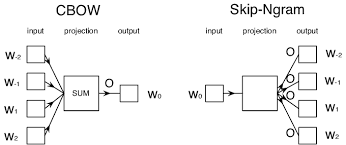

In [1]:
from IPython.display import Image #pip install IPython
Image("image/cbow_vs_skipgram.png") 


# Implemention of Skip-Gram

스킵그램은 (대상 다넝, 맥락 단어)의 쌍으로 표현할 수 있다.

이때, 대상 단어는 입력이고 맥락 단어는 예측할 단어이다. 

아래 표와 같이 같은 대상이라도 맥락 크기에 따라서 스킵그램 수가 달라진다.

|맥락 크기|텍스트|스킵그램|
|------|---|---|
|1|**the train** was late|('the', 'train')|
|1|**the train was** late|('train', 'the'), ('train', 'was')|
|1|the **train was late**|('was', 'train'), ('was', 'late')|
|1|the train **was late**|('late', 'was')|
|2|**the train** was late|('the', 'train'), ('the', 'was')|
|2|**the train was late**|('train', 'the'), ('train', 'was'), ('train', 'late')|
|2|**the train was late**|('was', 'the'), ('was', 'train'), ('was', 'late')|
|2|the **train was late**|('late', 'train'), ('late', 'was')|


## Package

In [ ]:
# package
import numpy as np
import pandas as pd
from transformers import AutoTokenizer
from collections import defaultdict
from tqdm import tqdm
tqdm.pandas()
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, Dense, Input, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

## Utils

In [34]:
def compute_pair_scores(splits, word_freqs):
    letter_freqs = defaultdict(int)
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            letter_freqs[split[0]] += freq
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            letter_freqs[split[i]] += freq
            pair_freqs[pair] += freq
        letter_freqs[split[-1]] += freq

    scores = {
        pair: freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
        for pair, freq in pair_freqs.items()
    }
    return scores

def merge_pair(a, b, splits, word_freqs):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                merge = a + b[2:] if b.startswith("##") else a + b
                split = split[:i] + [merge] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

def wordpiece_tokenizer(corpus, vocab_size):
    print("Loading Tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    word_freqs = defaultdict(int)
    alphabet, vocab = [], []

    print("Initialize alphabet...")
    # append alphabet
    for text in corpus:
        words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
        new_words = [word for word, offset in words_with_offsets]
        for word in new_words:
            word_freqs[word] += 1

    for word in word_freqs.keys():
        if word[0] not in alphabet:
            alphabet.append(word[0])
        for letter in word[1:]:
            if f"##{letter}" not in alphabet:
                alphabet.append(f"##{letter}")

    print("Constructing vocabulary...")

    # append vocab
    vocab = vocab + alphabet.copy()

    splits = {
        word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)]
        for word in word_freqs.keys()
    }
    while len(vocab) < vocab_size:
        scores = compute_pair_scores(splits, word_freqs)
        best_pair, max_score = "", None
        for pair, score in scores.items():
            if max_score is None or max_score < score:
                best_pair = pair
                max_score = score
        splits = merge_pair(*best_pair, splits, word_freqs)
        new_token = (
            best_pair[0] + best_pair[1][2:]
            if best_pair[1].startswith("##")
            else best_pair[0] + best_pair[1]
        )
        vocab.append(new_token)

    return vocab


def encode_word(word, vocab):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

def tokenize(text, vocab):
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    encoded_words = [encode_word(word, vocab) for word in pre_tokenized_text]
    return sum(encoded_words, [])

def skipgram_input_generator(text, context_size):
    skipgrams = []
    for i in range(context_size, len(text) - context_size):
        array = [text[j] for j in np.arange(i - context_size, i + context_size + 1) if j != i]
        skipgrams.append((text[i], array))

    return skipgrams

def negative_sampling(df, n_samples=5):
    unique_input_2 = df["input_2"].unique()
    negative_samples = []
    
    for input_1 in df["input_1"].unique():
        # 해당 input_1에 대한 기존 positive input_2 값
        existing_input_2 = df[df["input_1"] == input_1]["input_2"].tolist()
        
        # 네거티브 샘플 후보에서 기존 input_2 제외
        negative_candidates = list(set(unique_input_2) - set(existing_input_2))
        
        # 네거티브 샘플 추출
        sampled_negatives = np.random.choice(negative_candidates, n_samples, replace=True)
        
        # 결과 추가
        for neg in sampled_negatives:
            negative_samples.append({"input_1": input_1, "input_2": neg, "output": 0})
    
    # 네거티브 샘플을 데이터프레임으로 변환
    return pd.DataFrame(negative_samples)

def preprocessing_data(df, TRAIN_SIZE): # Split data into 8/2
    df = shuffle(df, random_state=1)
    cutoff = int(TRAIN_SIZE * len(df))
    train_df = df.iloc[:cutoff]
    test_df = df.iloc[cutoff:]

    return train_df, test_df

def skipgram(word_num, dims):
    word_input_1 = Input(shape=(1,), dtype = "int32", name = "word_input_1")
    word_embedding_1 = Embedding(word_num, dims, input_length = word_input_1.shape[1], name = "input_1_Embedding")(word_input_1)
    word_embedding_1 = Flatten(name = "input_1_Flatten")(word_embedding_1)

    word_input_2 = Input(shape=(1,), dtype = "int32", name = "word_input_2")
    word_embedding_2 = Embedding(word_num, dims, input_length = word_input_2.shape[1], name = "input_2_Embedding")(word_input_2)
    word_embedding_2 = Flatten(name = "input_2_Flatten")(word_embedding_2)

    input_12 = Concatenate(name = "Concat_input_1_input_2")([word_embedding_1, word_embedding_2])
    outputs = Dense(1, activation = "sigmoid", name = "outputs")(input_12)

    model = Model(inputs = [word_input_1, word_input_2], outputs = outputs)

    return model

## Generate Data

### Load Data

In [7]:
text = """Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nunc eu sem 
scelerisque, dictum eros aliquam, accumsan quam. Pellentesque tempus, lorem ut 
semper fermentum, ante turpis accumsan ex, sit amet ultricies tortor erat quis 
nulla. Nunc consectetur ligula sit amet purus porttitor, vel tempus tortor 
scelerisque. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices 
posuere cubilia curae; Quisque suscipit ligula nec faucibus accumsan. Duis 
vulputate massa sit amet viverra hendrerit. Integer maximus quis sapien id 
convallis. Donec elementum placerat ex laoreet gravida. Praesent quis enim 
facilisis, bibendum est nec, pharetra ex. Etiam pharetra congue justo, eget 
imperdiet diam varius non. Mauris dolor lectus, interdum in laoreet quis, 
faucibus vitae velit. Donec lacinia dui eget maximus cursus. Class aptent taciti
sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Vivamus
tincidunt velit eget nisi ornare convallis. Pellentesque habitant morbi 
tristique senectus et netus et malesuada fames ac turpis egestas. Donec 
tristique ultrices tortor at accumsan.
"""
corpus = text.split(".")

In [8]:
corpus[:5]

['Lorem ipsum dolor sit amet, consectetur adipiscing elit',
 ' Nunc eu sem \nscelerisque, dictum eros aliquam, accumsan quam',
 ' Pellentesque tempus, lorem ut \nsemper fermentum, ante turpis accumsan ex, sit amet ultricies tortor erat quis \nnulla',
 ' Nunc consectetur ligula sit amet purus porttitor, vel tempus tortor \nscelerisque',
 ' Vestibulum ante ipsum primis in faucibus orci luctus et ultrices \nposuere cubilia curae; Quisque suscipit ligula nec faucibus accumsan']

### Tokenize Corpus (using WordPiece)

In [9]:
vocab = wordpiece_tokenizer(corpus, 100)
tokenized_text = tokenize(text, vocab)

Loading Tokenizer...
Initialize alphabet...
Constructing vocabulary...


In [10]:
CONTEXT_SIZE = 2
skipgrams = skipgram_input_generator(tokenized_text, CONTEXT_SIZE)

In [11]:
skipgrams[:2]

[('##m', ['Lor', '##e', 'ip', '##s']), ('ip', ['##e', '##m', '##s', '##u'])]

### Generate Word2Vec Dataset(using negative sampling)

In [12]:
word2vec_df = pd.DataFrame(columns=["input_1", "input_2", "output"])

In [13]:
word2vec_df


,input_1,input_2,output


In [14]:
for i in tqdm(range(len(skipgrams))):
    tuple_ = skipgrams[i]
    input1 = tuple_[0]
    input2_list = tuple_[1]
    for j in range(len(input2_list)):
        word2vec_df = pd.concat([word2vec_df,
                                 pd.DataFrame([{
                                     "input_1": input1,
                                     "input_2": input2_list[j],
                                     "output": 1
                                 }])
        ])

100%|██████████| 841/841 [00:01<00:00, 579.20it/s]


In [15]:
word2vec_df.head()

,input_1,input_2,output
0,##m,Lor,1
0,##m,##e,1
0,##m,ip,1
0,##m,##s,1
0,ip,##e,1


In [16]:

# 네거티브 샘플 추가
negative_df = negative_sampling(word2vec_df, n_samples=5)

# 기존 데이터와 병합
result_df = pd.concat([word2vec_df, negative_df])

In [20]:
result_df.sample(5)

,input_1,input_2,output
0,##c,a,1
97,##l,convall,0
0,##u,##i,1
0,##m,##t,1
328,ornar,##r,0


In [27]:
le = LabelEncoder()
# input_1과 input_2의 값을 합쳐 고유값 추출
combined_values = pd.concat([result_df["input_1"], result_df["input_2"]], axis=0).unique()

# 고유값 라벨 인코딩
le.fit(combined_values)

# input_1과 input_2를 라벨 인코딩
result_df["input_1"] = le.transform(result_df["input_1"])
result_df["input_2"] = le.transform(result_df["input_2"])
print(f"max value of input_1: {result_df['input_1'].max()}")
print(f"max value of input_2: {result_df['input_2'].max()}")

max value of input_1: 68
max value of input_2: 68


In [22]:
result_df.head()

,input_1,input_2,output
0,8,25,1
0,8,4,1
0,8,50,1
0,8,14,1
0,50,4,1


In [25]:
train_df, test_df = preprocessing_data(result_df, 0.8)
print(f"The length of train dataset: {len(train_df)}")
print(f"The length of test dataset: {len(test_df)}")

The length of train dataset: 2963
The length of test dataset: 741


In [ ]:
train_input_1 = train_df["input_1"].values
train_input_2 = train_df["input_2"].values
train_output = train_df["output"].values

test_input_1 = test_df["input_1"].values
test_input_2 = test_df["input_2"].values
test_output = test_df["output"].values

### Initiation

In [ ]:
skipgram = skipgram(68, 100)
skipgram.summary()

adam = Adam(learning_rate=0.0001)

skipgram.compile(optimizer=adam, loss=BinaryCrossentropy)
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 5, restore_best_weights = True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 word_input_1 (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 word_input_2 (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 input_1_Embedding (Embeddi  (None, 1, 100)               6800      ['word_input_1[0][0]']        
 ng)                                                                                              
                                                                                                  
 input_2_Embedding (Embeddi  (None, 1, 100)               6800      ['word_input_2[0][0]']  

### Train & Test

In [ ]:
history = skipgram.fit([train_input_1, train_input_2],
              train_output,
              batch_size = 32,
              epochs = 50,
              callbacks=[es],
              validation_split = 0.125)

In [ ]:
y_pred_binary = (skipgram.predict([test_input_1, test_input_2]) >= 0.5).astype(int)

# 모델 성능 평가 지표 계산 및 출력
metrics = {
    "Precision": precision_score(test_output, y_pred_binary) * 100,
    "Recall": recall_score(test_output, y_pred_binary) * 100,
    "F1_Score": f1_score(test_output, y_pred_binary) * 100,
    "Accuracy": accuracy_score(test_output, y_pred_binary) * 100
}

In [ ]:
print(f"Precision: {round(metrics["Precision"], 3)}")
print(f"Recall: {round(metrics["Recall"], 3)}")
print(f"F1_Score: {round(metrics["F1_Score"], 3)}")
print(f"Accuracy: {round(metrics["Accuracy"], 3)}")